In [200]:
import numpy as np
import sympy
import scipy

import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import tf2ss

import control as ct

from tqdm import tqdm

In [201]:
M = 0.4  # Масса тележки
m = 0.2  # Масса маятника
l = 0.25 # Длинна маятника
g = 9.8  # Ускорение свободного падения
f = 0.0  # Начальная сила 

# Уравнения объекта в форме Коши

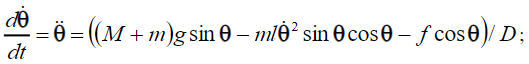
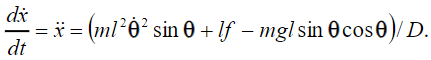

In [202]:
def koshi(y, t):
    """
    y - векрот состояния
        x - положение в пространстве
        theta - угол
        dtheta - скрость имзменения угла
        dx - скорость коретки 
    t - время 
    """
    theta, dtheta, x, dx = y
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    denominator = (M + m)*l - m*l*cos_theta**2
    
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - f*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*f - m*g*l*sin_theta*cos_theta) / denominator
    
    return [dtheta, ddtheta, dx, ddx]

### Моделируем

In [203]:
def model(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    """
    func - функция управления

    theta0 - начальный угол

    dtheta0 - начальная скорость изменения угла
    
    ts - время
    
    nt - шаг дискретизации времени
    
    x0 - начальная точка коретки
    
    dx0 - начальная скорость коретки
    """
    initial_conditions = [theta0, dtheta0, x0, dx0]
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

100%|██████████| 180/180 [00:04<00:00, 42.19it/s]


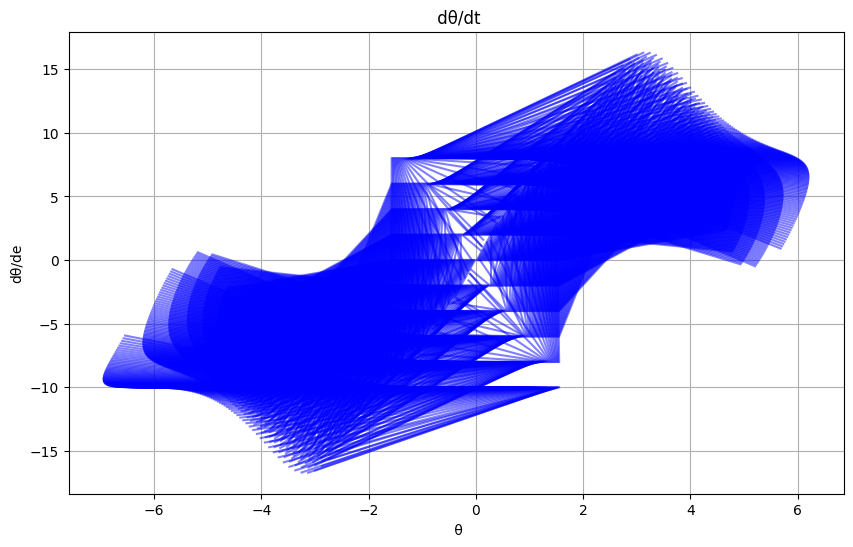

In [204]:
plt.figure(figsize=(10, 6))
    
radian_line = np.arange(
    np.radians(-90),
    np.radians(90),
    np.radians(1)
)

for theta0 in tqdm(radian_line):
    for dtheta0 in np.arange(-10, 10, 2):
        sol = model(koshi, theta0, dtheta0, 1, 0.5)
        plt.plot(sol[:, 0], sol[:, 1], 'b', alpha=0.5)  
    
plt.xlabel(' θ')
plt.ylabel('dθ/dе')
plt.title(' dθ/dt')
plt.grid()

plt.show()
    

# Моделирование физ модели

In [205]:
stats = model(koshi, 1, 0, 100, 0.1)

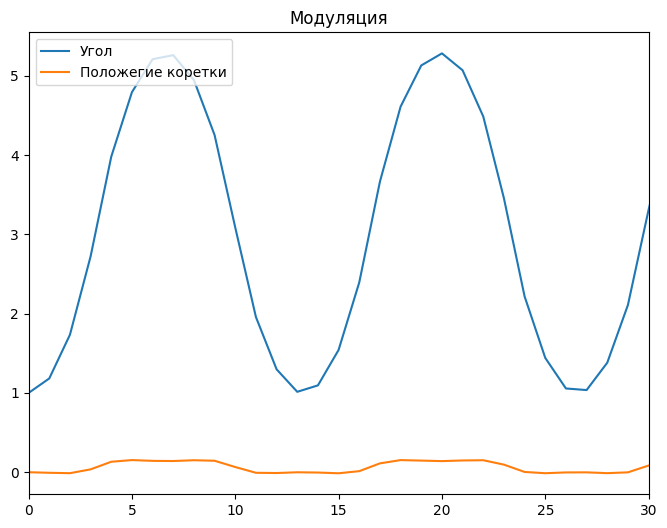

In [206]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.xlim(0, 30)

plt.legend(loc = 'upper left')


plt.title('Модуляция')
plt.show()

# Линеризация уравнений

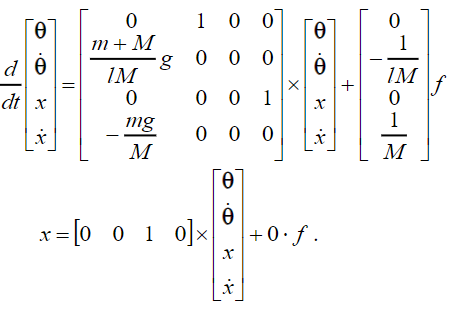
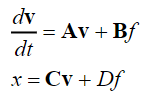

In [207]:
A = np.array([
    [0, 1, 0, 0],
    [(M+m)*g/(l*M), 0, 0, 0],
    [0, 0, 0, 1],
    [-m*g/M, 0, 0, 0]
])

B = np.array([
    [0], [-1/(l*M)], [0], [1/M]
    ])
C = np.array([[0, 0, 1, 0]])
D = np.array([[0]])

C_theta = np.array([[1, 0, 0, 0]])

## Передаточная функция

### Создаем систему

In [208]:
sys = ct.ss(A, B, C, D)
sys

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [58.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [-4.9,  0. ,  0. ,  0. ]]), array([[  0. ],
       [-10. ],
       [  0. ],
       [  2.5]]), array([[0., 0., 1., 0.]]), array([[0.]]))

In [209]:
G = ct.ss2tf(sys)
G

TransferFunction(array([ 1.74860126e-15,  2.50000000e+00,  4.61149518e-15, -9.80000000e+01]), array([  1. ,   0. , -58.8,   0. ,   0. ]))

In [210]:
A_s = G.num[0][0]
A_s

array([ 1.74860126e-15,  2.50000000e+00,  4.61149518e-15, -9.80000000e+01])

In [211]:
B_s = G.den[0][0]
B_s

array([  1. ,   0. , -58.8,   0. ,   0. ])

## Наблюдаемость

### Наблюдаемость по углу


In [212]:
nabl = ct.obsv(A, C_theta)
print(f"Рaзмер матрици наблюдаемости {nabl.shape}")
print(f"Ранг матрици наблюдаемости: {np.linalg.matrix_rank(nabl)}")

Рaзмер матрици наблюдаемости (4, 4)
Ранг матрици наблюдаемости: 2


Система не наблюдаема по углу

### Наблюдаемость по положению коретки

In [213]:
nabl = ct.obsv(A, C)
print(f"Рaзмер матрици наблюдаемости {nabl.shape}")
print(f"Ранг матрици наблюдаемости: {np.linalg.matrix_rank(nabl)}")

Рaзмер матрици наблюдаемости (4, 4)
Ранг матрици наблюдаемости: 4


Система наблюдаема по положению коретки

## Управляемсть

In [214]:
upr = ct.ctrb(A, B)

print(f"Ранг матрици упрвляемости: {np.linalg.matrix_rank(upr)}")

Ранг матрици упрвляемости: 4


Система управляема

# Анализ устойчивости положения равновесия

### Полюса и нули

In [215]:
poles = ct.poles(sys)
poles

array([ 0.        +0.j,  0.        +0.j,  7.66811581+0.j, -7.66811581+0.j])

In [216]:
zeros = ct.zeros(sys)
zeros

array([-6.26099034+0.j,  6.26099034+0.j])

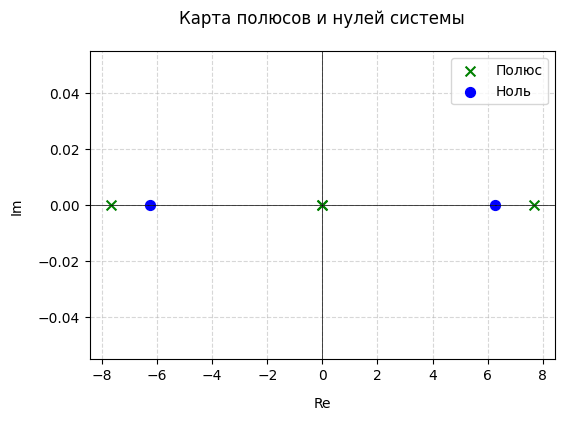

In [217]:
plt.figure(figsize=(6, 4))
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='g', s=50, label='Полюс')
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='b', s=50, label='Ноль')

plt.legend()

plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.5)

plt.title('Карта полюсов и нулей системы', pad=20)
plt.xlabel('Re', labelpad=10)
plt.ylabel('Im', labelpad=10)
plt.legend()

Системма не устойчева

# Синтез регулятора

### Задаем переменные

In [218]:
from sympy.abc import s
from sympy.physics.control.lti import TransferFunction as tf
from sympy.physics import control as sct

In [219]:
a_1, a_2, a_3, a_0 = sympy.symbols('a_1, a_2, a_3, a_0')
b_1, b_2, b_0 = sympy.symbols('b_1, b_2, b_0')

### Исходная функция системы

In [220]:
A_o = 1/M*(s**2-g/l)
B_o = (s**2*(s**2-(M+m)/(l*M)*g))
W_o = A_o/B_o
W_o

(2.5*s**2 - 98.0)/(s**2*(s**2 - 58.8))

### Функция регулятора

In [221]:
A_p = (a_3*s**3+a_2*s**2+a_1*s+a_0) 
B_p = (s**3+b_2*s**2+b_1*s+b_0)
W_p = A_p/B_p
W_p

(a_0 + a_1*s + a_2*s**2 + a_3*s**3)/(b_0 + b_1*s + b_2*s**2 + s**3)

In [222]:
A_s = A_o*B_p
B_s = A_o*A_p + B_o*B_p
W_s = sympy.together(A_s/B_s)
W_s

(2.5*s**2 - 98.0)*(b_0 + b_1*s + b_2*s**2 + s**3)/(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3))

In [223]:
a = [-0.2, -0.4, -1, -1.2247, -2, -4, -8]
polynom = sympy.prod(sympy.Array([s]*7)-sympy.Array(a))
polynom = sympy.cancel(polynom)
polynom = (s + 1)**7
polynom

(s + 1)**7

In [224]:
eq = sympy.Eq(B_s, polynom)
eq

Eq(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3), (s + 1)**7)

In [225]:
solv = sympy.solve(eq, [a_1, a_2, a_3, a_0, b_1, b_2, b_0])
solv

{a_0: -0.0102040816326531,
 a_1: -0.0714285714285714,
 a_2: 536.349092044981,
 a_3: 96.4779300291545,
 b_0: -894.272730112453,
 b_1: -161.394825072886,
 b_2: 7.00000000000000}

In [226]:
W_s = sympy.together(A_s/B_s).subs(solv)

In [227]:
a_0, a_1, a_2, a_3, b_0, b_1, b_2 = solv.values()

### Передаточная функция регулятора

In [228]:
W_p = tf((a_3*s**3+a_2*s**2+a_1*s+a_0) ,(s**3+b_2*s**2+b_1*s+b_0), var = s)
W_p

TransferFunction(96.4779300291545*s**3 + 536.349092044981*s**2 - 0.0714285714285714*s - 0.0102040816326531, s**3 + 7.0*s**2 - 161.394825072886*s - 894.272730112453, s)

In [229]:
W_o = tf(1/M*(s**2-g/l), (s**2*(s**2-(M+m)/(l*M)*g)), var = s)
W_o

TransferFunction(2.5*s**2 - 98.0, s**2*(s**2 - 58.8), s)

## Анализ линейной системы 

### Передаточная функция замкнутой системы

In [230]:
W_s_ = sct.Feedback(W_o, W_p).doit(cancel=True, expand=True)
W_s_

TransferFunction(2.5*s**5 + 17.5*s**4 - 501.487062682216*s**3 - 2921.68182528113*s**2 + 15816.6928571429*s + 87638.7275510204, s**7 + 7.0*s**6 + 21.0*s**5 + 35.0*s**4 + 35.0000000000036*s**3 + 21.0000000000073*s**2 + 7.0*s + 1.0, s)

### Cобственные значения замкнутой системы

In [231]:
W_s_den = W_s_.den
W_s_den

s**7 + 7.0*s**6 + 21.0*s**5 + 35.0*s**4 + 35.0000000000036*s**3 + 21.0000000000073*s**2 + 7.0*s + 1.0

In [232]:
eq = sympy.Eq(W_s_den, 0)
eq

Eq(s**7 + 7.0*s**6 + 21.0*s**5 + 35.0*s**4 + 35.0000000000036*s**3 + 21.0000000000073*s**2 + 7.0*s + 1.0, 0)

In [233]:
solv = sympy.solve(eq, s)
solv

[-0.977045709264503,
 -1.02103174572788 - 0.010239944938244*I,
 -1.02103174572788 + 0.010239944938244*I,
 -1.00495087814218 - 0.0227019627584708*I,
 -1.00495087814218 + 0.0227019627584708*I,
 -0.985494521497682 - 0.0179016361118717*I,
 -0.985494521497682 + 0.0179016361118717*I]

С учетом погрешности корни совпадают

##  Компьютерное моделирование нелинейной системы 
 


### Матрица параметров

In [234]:
W_p_num = np.array(sympy.Poly(W_p.num, s).all_coeffs()).astype(np.float32)
W_p_den = np.array(sympy.Poly(W_p.den, s).all_coeffs()).astype(np.float32)

In [235]:
A_, B_, C_, D_ = tf2ss(W_p_num, W_p_den)

In [236]:
reg = ct.ss(A_, B_, C_, D_)
reg

StateSpace(array([[ -7.        , 161.39482117, 894.27270508],
       [  1.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ]]), array([[1.],
       [0.],
       [0.]]), array([[ -138.99639893, 15570.96679688, 86277.5703125 ]]), array([[96.47792816]]))

In [237]:
sys

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [58.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [-4.9,  0. ,  0. ,  0. ]]), array([[  0. ],
       [-10. ],
       [  0. ],
       [  2.5]]), array([[0., 0., 1., 0.]]), array([[0.]]))

In [238]:
sys_reg = ct.feedback(sys, reg)
sys_reg

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.88000000e+01,  0.00000000e+00,  9.64779282e+02,
         0.00000000e+00, -1.38996399e+03,  1.55709668e+05,
         8.62775703e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.90000000e+00,  0.00000000e+00, -2.41194820e+02,
         0.00000000e+00,  3.47490997e+02, -3.89274170e+04,
        -2.15693926e+05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -7.00000000e+00,  1.61394821e+02,
         8.94272705e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
       

### Функции моделирования

In [239]:
def regul_sys(y, t):
    """
    y - векрот состояния
        x - положение в пространстве
        theta - угол
        dtheta - скрость имзменения угла
        dx - скорость коретки 
        0,
        0, 
        0
    t - время 
    """
    dy = sys_reg.A@y+sys_reg.B.reshape(-1)*f
    
    return dy

In [240]:
def model_reg(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    """
    func - функция управления

    theta0 - начальный угол

    dtheta0 - начальная скорость изменения угла
    
    ts - время
    
    nt - шаг дискретизации времени
    
    x0 - начальная точка коретки
    
    dx0 - начальная скорость коретки
    """
    initial_conditions = np.array([theta0, dtheta0, x0, dx0, 0, 0, 0])
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

### Модуляция

In [241]:
stats = model_reg(regul_sys, 0.08, 0, 100, 0.1)

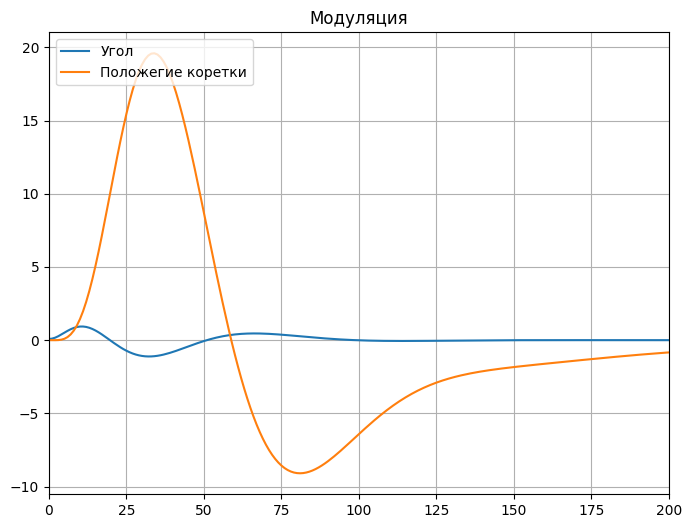

In [244]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.legend(loc = 'upper left')
plt.xlim(0, 200)
plt.grid()
plt.title('Модуляция')
plt.show()